In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt


#read in + edit SP 500 value
sp500_df = pd.read_csv("sp500adj.csv")
sp500_df['Date'] = pd.to_datetime(sp500_df['Date'])
sp500_df['date_month'] = sp500_df['Date'].dt.strftime('%Y.%m')
sp500_df = sp500_df.rename(columns={"Value":"SP500 Index Value ($)"})
#sp500_df


#read in + edit geopolitical risk (GPR)
#"Higher geopolitical risk foreshadows lower investment, stock prices, and employment"
gpr_df_raw = pd.read_csv("data_gpr_export.csv")
gpr_df_raw['Date'] = pd.to_datetime(gpr_df_raw['month'])
gpr_df_raw['date_month'] = gpr_df_raw['Date'].dt.strftime('%Y.%m')
us_gpr_df = gpr_df_raw[['date_month','GPRC_USA']]


#read in + edit GDP with inflation adjusted
#note: had to remove first two lines in the dataset in order to actually read it
#those only contained the data source and last edit time:
#"Data Source","World Development Indicators",
#"Last Updated Date","2025-10-07",
GDP_df = pd.read_csv("GDP/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_130122.csv")
GDP_df = GDP_df[GDP_df['Country Code'] == 'USA']
gdp_usa = GDP_df.melt(
    id_vars=['Country Code','Country Name','Indicator Name','Indicator Code'],
    var_name='Year', value_name='GDP'
)
gdp_usa = gdp_usa.rename(columns={"GDP":"US GDP inflation adjusted ($)"})
gdp_usa = gdp_usa[gdp_usa['Year'].str.isnumeric()].copy()
gdp_usa['Year'] = gdp_usa['Year'].astype(int)
#gdp_usa


#read in + edit federal funds rate
fed_df = pd.read_csv("FEDFUNDS.csv")
fed_df['observation_date'] = pd.to_datetime(fed_df['observation_date'])
fed_df['Year'] = fed_df['observation_date'].dt.year
fed_df['FEDFUNDS'] = pd.to_numeric(fed_df['FEDFUNDS'], errors='coerce')
fed_df = fed_df.groupby('Year', as_index=False)['FEDFUNDS'].mean()


#read in + edit CPI (Consumer Price Index)
cpi_df = pd.read_csv("CPIAUCSL.csv")
cpi_df['observation_date'] = pd.to_datetime(cpi_df['observation_date'])
cpi_df['Year'] = cpi_df['observation_date'].dt.year
cpi_df['CPIAUCSL'] = pd.to_numeric(cpi_df['CPIAUCSL'], errors='coerce')
cpi_df = cpi_df.groupby('Year', as_index=False)['CPIAUCSL'].mean()
cpi_df = cpi_df.rename(columns={"CPIAUCSL":"CPI"})


#read in + edit unemployment rate
unrate_df = pd.read_csv("UNRATE.csv")
unrate_df['observation_date'] = pd.to_datetime(unrate_df['observation_date'])
unrate_df['Year'] = unrate_df['observation_date'].dt.year
unrate_df['UNRATE'] = pd.to_numeric(unrate_df['UNRATE'], errors='coerce')
unrate_df = unrate_df.groupby('Year', as_index=False)['UNRATE'].mean()
unrate_df = unrate_df.rename(columns={"UNRATE":"UNEMPLOYMENT RATE"})


#read in + edit VIX (Volatility Index)
vix_df = pd.read_csv("VIXCLS.csv")
vix_df['observation_date'] = pd.to_datetime(vix_df['observation_date'])
vix_df['Year'] = vix_df['observation_date'].dt.year
vix_df['VIXCLS'] = pd.to_numeric(vix_df['VIXCLS'], errors='coerce')
vix_df = vix_df.groupby('Year', as_index=False)['VIXCLS'].mean()
vix_df = vix_df.rename(columns={"VIXCLS":"VIX"})


#merging all the dataframes (by year)
merged_df = pd.merge(sp500_df, us_gpr_df, on='date_month', how='inner').dropna()
merged_df['Year'] = merged_df['Date'].dt.year
annual_df = merged_df.groupby('Year', as_index=False).agg({
    'SP500 Index Value ($)': 'mean',
    'GPRC_USA': 'mean'
})
merged_yearly_df = pd.merge(annual_df, gdp_usa[['Year','US GDP inflation adjusted ($)']], on='Year', how='inner')
merged_yearly_df = pd.merge(merged_yearly_df, fed_df, on='Year', how='left')
merged_yearly_df = pd.merge(merged_yearly_df, cpi_df, on='Year', how='left')
merged_yearly_df = pd.merge(merged_yearly_df, unrate_df, on='Year', how='left')
merged_yearly_df = pd.merge(merged_yearly_df, vix_df, on='Year', how='left')
#merged_yearly_df


#merging all the datasets (by year + month, doesn't include GDP)
merged_df = pd.merge(sp500_df, us_gpr_df, on='date_month', how='inner').dropna()
fed_df = pd.read_csv("FEDFUNDS.csv")
fed_df['observation_date'] = pd.to_datetime(fed_df['observation_date'])
fed_df['date_month'] = fed_df['observation_date'].dt.strftime('%Y.%m')
fed_df = fed_df[['date_month', 'FEDFUNDS']]
merged_monthly_df = pd.merge(merged_df, fed_df, on='date_month', how='left')

#read in + edit CPI for monthly merge
cpi_df_monthly = pd.read_csv("CPIAUCSL.csv")
cpi_df_monthly['observation_date'] = pd.to_datetime(cpi_df_monthly['observation_date'])
cpi_df_monthly['date_month'] = cpi_df_monthly['observation_date'].dt.strftime('%Y.%m')
cpi_df_monthly['CPIAUCSL'] = pd.to_numeric(cpi_df_monthly['CPIAUCSL'], errors='coerce')
cpi_df_monthly = cpi_df_monthly.groupby('date_month', as_index=False)['CPIAUCSL'].mean()
cpi_df_monthly = cpi_df_monthly.rename(columns={"CPIAUCSL":"CPI"})
cpi_df_monthly = cpi_df_monthly[['date_month', 'CPI']]

#read in + edit unemployment rate for monthly merge
unrate_df_monthly = pd.read_csv("UNRATE.csv")
unrate_df_monthly['observation_date'] = pd.to_datetime(unrate_df_monthly['observation_date'])
unrate_df_monthly['date_month'] = unrate_df_monthly['observation_date'].dt.strftime('%Y.%m')
unrate_df_monthly['UNRATE'] = pd.to_numeric(unrate_df_monthly['UNRATE'], errors='coerce')
unrate_df_monthly = unrate_df_monthly.groupby('date_month', as_index=False)['UNRATE'].mean()
unrate_df_monthly = unrate_df_monthly.rename(columns={"UNRATE":"UNEMPLOYMENT RATE"})
unrate_df_monthly = unrate_df_monthly[['date_month', 'UNEMPLOYMENT RATE']]

#read in + edit VIX for monthly merge
vix_df_monthly = pd.read_csv("VIXCLS.csv")
vix_df_monthly['observation_date'] = pd.to_datetime(vix_df_monthly['observation_date'])
vix_df_monthly['date_month'] = vix_df_monthly['observation_date'].dt.strftime('%Y.%m')
vix_df_monthly['VIXCLS'] = pd.to_numeric(vix_df_monthly['VIXCLS'], errors='coerce')
vix_df_monthly = vix_df_monthly.groupby('date_month', as_index=False)['VIXCLS'].mean()
vix_df_monthly = vix_df_monthly.rename(columns={"VIXCLS":"VIX"})
vix_df_monthly = vix_df_monthly[['date_month', 'VIX']]

#merge all monthly datasets
merged_monthly_df = pd.merge(merged_monthly_df, cpi_df_monthly, on='date_month', how='left')
merged_monthly_df = pd.merge(merged_monthly_df, unrate_df_monthly, on='date_month', how='left')
merged_monthly_df = pd.merge(merged_monthly_df, vix_df_monthly, on='date_month', how='left')
merged_monthly_df = merged_monthly_df.sort_values('Date')
merged_monthly_df = merged_monthly_df.set_index('Date')

# Rename columns: CPIAUCSL -> CPI, UNRATE -> UNEMPLOYMENT RATE, VIXCLS -> VIX
merged_monthly_df = merged_monthly_df.rename(columns={
    'CPIAUCSL': 'CPI',
    'UNRATE': 'UNEMPLOYMENT RATE',
    'VIXCLS': 'VIX'
})

# Rename columns in yearly dataset
merged_yearly_df = merged_yearly_df.rename(columns={
    'CPIAUCSL': 'CPI',
    'UNRATE': 'UNEMPLOYMENT RATE',
    'VIXCLS': 'VIX'
})

# To view the datasets, uncomment the following:
# merged_monthly_df
# merged_yearly_df

## data view
You can check Yearly dataset -> merged_yearly_df
You can check Monyhly dataset -> merged_monthly_df

In [2]:
# Add CHANGE RATE columns for each feature showing percentage change from previous month/year
# For merged_monthly_df and merged_yearly_df

import numpy as np

# Function to add CHANGE RATE columns next to each numeric column
def add_change_rate_columns(df, exclude_cols=None):
    """
    Add CHANGE RATE columns next to each numeric column.
    Each row shows the percentage change from the previous period.
    """
    if exclude_cols is None:
        exclude_cols = []
    
    df_with_changes = df.copy()
    
    # Get numeric columns excluding specified ones
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
    
    # Create new dataframe with reordered columns
    new_columns = []
    
    for col in df.columns:
        new_columns.append(col)
        # If this is a numeric column, add CHANGE RATE column right after it
        if col in numeric_cols:
            change_col_name = col.replace(' Index Value ($)', ' CHANGE RATE').replace(' ($)', ' CHANGE RATE').replace('_', ' ').title().replace(' ', ' ') + ' CHANGE RATE'
            # Simplify the name
            if 'SP500' in col:
                change_col_name = 'SP500 CHANGE RATE'
            elif 'GPRC_USA' in col or 'GPRC' in col:
                change_col_name = 'GPRC CHANGE RATE'
            elif 'FEDFUNDS' in col or 'FEDFUNDS' in col:
                change_col_name = 'FEDFUNDS CHANGE RATE'
            elif 'CPI' in col and 'CHANGE' not in col:
                change_col_name = 'CPI CHANGE RATE'
            elif 'UNEMPLOYMENT' in col or 'UNRATE' in col:
                change_col_name = 'UNEMPLOYMENT RATE CHANGE RATE'
            elif 'VIX' in col and 'CHANGE' not in col:
                change_col_name = 'VIX CHANGE RATE'
            elif 'GDP' in col:
                change_col_name = 'GDP CHANGE RATE'
            
            # Calculate percentage change
            df_with_changes[change_col_name] = df[col].pct_change(fill_method=None) * 100
            new_columns.append(change_col_name)
    
    # Reorder columns
    df_with_changes = df_with_changes[new_columns]
    
    return df_with_changes

# Apply to merged_monthly_df
merged_monthly_df_with_changes = add_change_rate_columns(merged_monthly_df, exclude_cols=['date_month'])

# Apply to merged_yearly_df
merged_yearly_df_with_changes = add_change_rate_columns(merged_yearly_df, exclude_cols=['Year'])

# To view the datasets, uncomment the following:
# merged_monthly_df_with_changes
# merged_yearly_df_with_changes



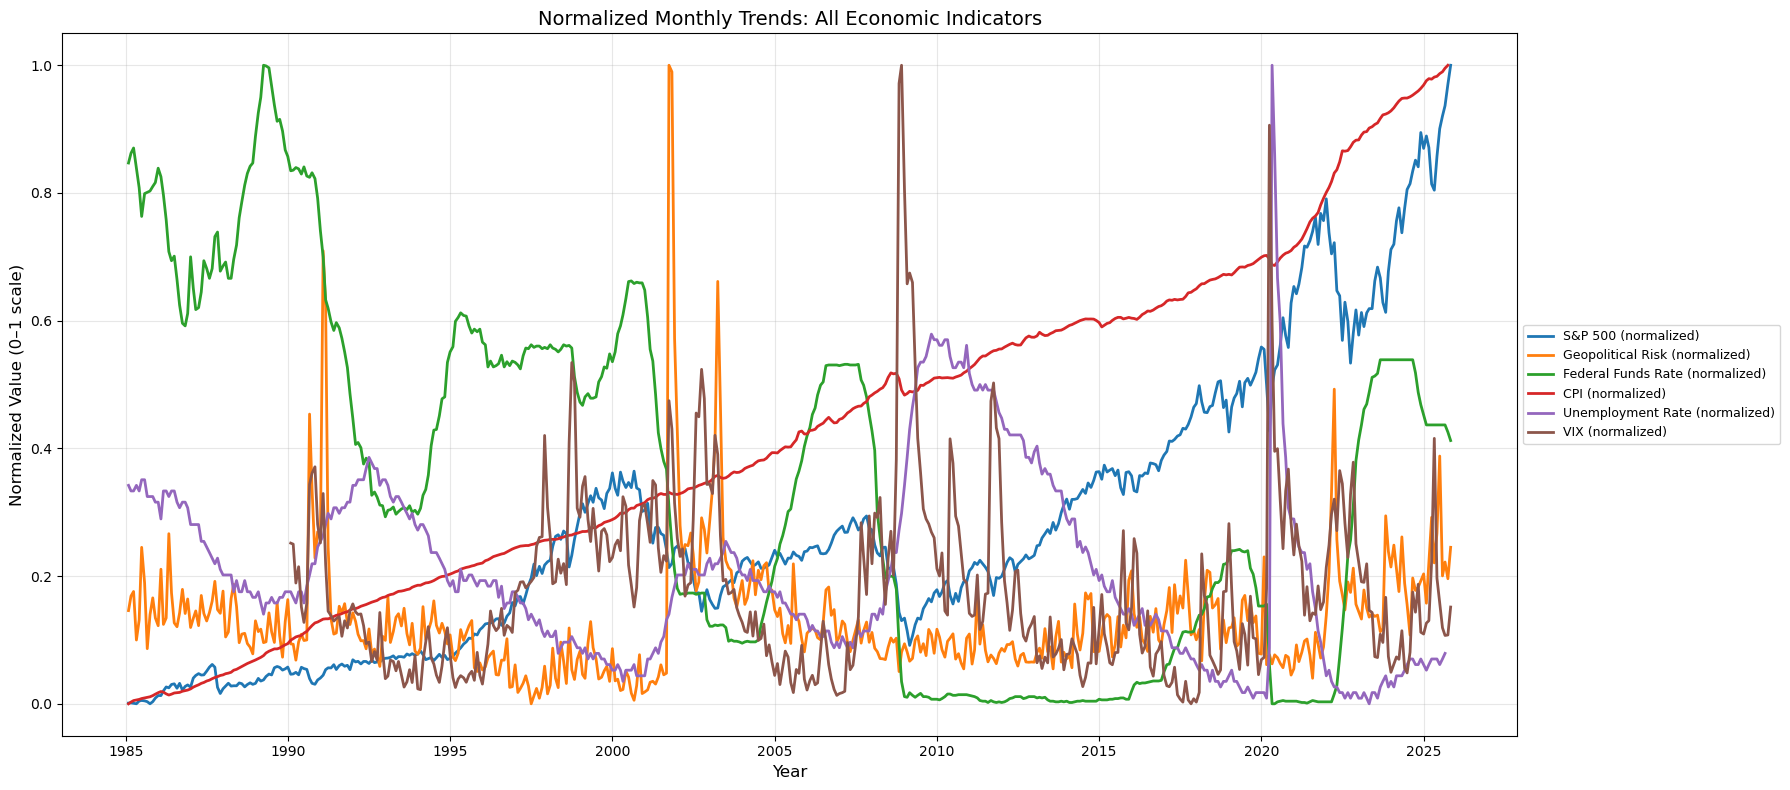

In [3]:
# Normalized graph for monthly dataset
normalized_df = merged_monthly_df.copy()

# Normalize all numeric columns
original_cols = ['SP500 Index Value ($)', 'GPRC_USA', 'FEDFUNDS', 'CPI', 'UNEMPLOYMENT RATE', 'VIX']

# Normalize original columns
for col in original_cols:
    if col in normalized_df.columns:
        normalized_df[col + '_norm'] = (
            normalized_df[col] - normalized_df[col].min()
        ) / (normalized_df[col].max() - normalized_df[col].min())

plt.figure(figsize=(18,8))
# Plot original normalized values
plt.plot(normalized_df.index, normalized_df['SP500 Index Value ($)_norm'], label='S&P 500 (normalized)', linewidth=2)
plt.plot(normalized_df.index, normalized_df['GPRC_USA_norm'], label='Geopolitical Risk (normalized)', linewidth=2)
plt.plot(normalized_df.index, normalized_df['FEDFUNDS_norm'], label='Federal Funds Rate (normalized)', linewidth=2)
if 'CPI_norm' in normalized_df.columns:
    plt.plot(normalized_df.index, normalized_df['CPI_norm'], label='CPI (normalized)', linewidth=2)
if 'UNEMPLOYMENT RATE_norm' in normalized_df.columns:
    plt.plot(normalized_df.index, normalized_df['UNEMPLOYMENT RATE_norm'], label='Unemployment Rate (normalized)', linewidth=2)
if 'VIX_norm' in normalized_df.columns:
    plt.plot(normalized_df.index, normalized_df['VIX_norm'], label='VIX (normalized)', linewidth=2)

plt.title("Normalized Monthly Trends: All Economic Indicators", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Normalized Value (0–1 scale)", fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#during spikes in GPR there are sometimes falls in the economy?
#something to investigate might be growth/loss in the SP 500 instead of just total value

## data view (After NaN processing -> If you want to delete NaN in VIX colmun)
You can check Yearly dataset -> merged_yearly_df_clean
You can check Monyhly dataset -> merged_monthly_df_clean

In [4]:
# Selective Removal - Remove rows with NaN in VIX column
# This approach minimizes data loss while ensuring VIX has complete data

# For Monthly Dataset: Remove rows where VIX is NaN
merged_monthly_df_clean = merged_monthly_df.dropna(subset=['VIX'])

# For Yearly Dataset: Remove rows where VIX is NaN
merged_yearly_df_clean = merged_yearly_df.dropna(subset=['VIX'])

# To view the datasets, uncomment the following:
# merged_monthly_df_clean
# merged_yearly_df_clean

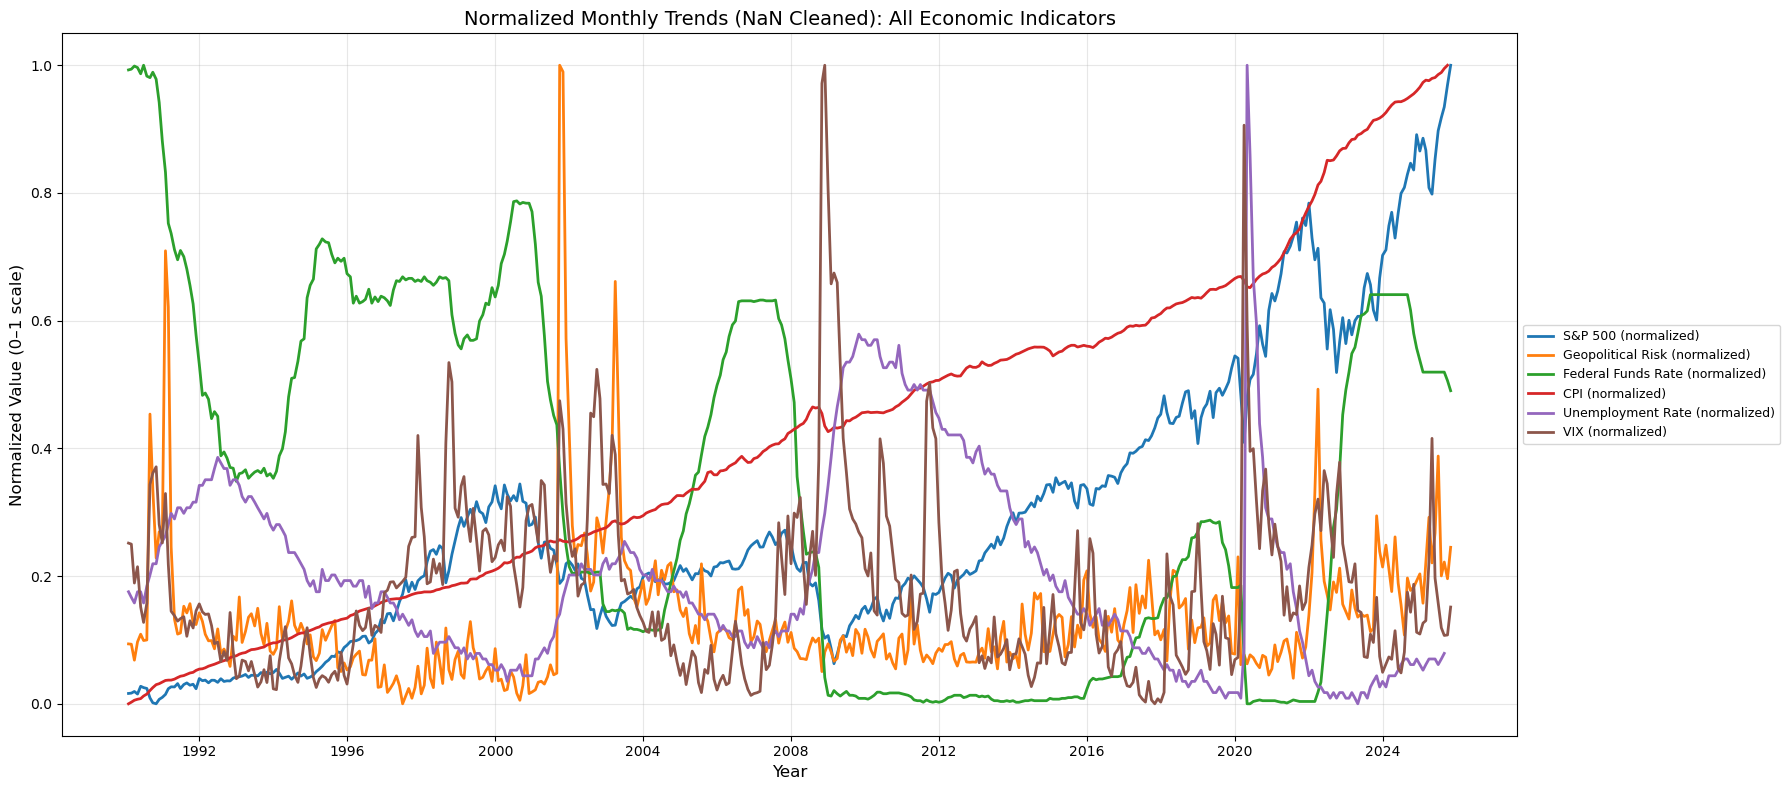

In [5]:
# Normalized graph for NaN cleaned dataset
normalized_df_clean = merged_monthly_df_clean.copy()

# Normalize all numeric columns
original_cols = ['SP500 Index Value ($)', 'GPRC_USA', 'FEDFUNDS', 'CPI', 'UNEMPLOYMENT RATE', 'VIX']

# Normalize original columns
for col in original_cols:
    if col in normalized_df_clean.columns:
        normalized_df_clean[col + '_norm'] = (
            normalized_df_clean[col] - normalized_df_clean[col].min()
        ) / (normalized_df_clean[col].max() - normalized_df_clean[col].min())

plt.figure(figsize=(18,8))
# Plot original normalized values
plt.plot(normalized_df_clean.index, normalized_df_clean['SP500 Index Value ($)_norm'], label='S&P 500 (normalized)', linewidth=2)
plt.plot(normalized_df_clean.index, normalized_df_clean['GPRC_USA_norm'], label='Geopolitical Risk (normalized)', linewidth=2)
plt.plot(normalized_df_clean.index, normalized_df_clean['FEDFUNDS_norm'], label='Federal Funds Rate (normalized)', linewidth=2)
if 'CPI_norm' in normalized_df_clean.columns:
    plt.plot(normalized_df_clean.index, normalized_df_clean['CPI_norm'], label='CPI (normalized)', linewidth=2)
if 'UNEMPLOYMENT RATE_norm' in normalized_df_clean.columns:
    plt.plot(normalized_df_clean.index, normalized_df_clean['UNEMPLOYMENT RATE_norm'], label='Unemployment Rate (normalized)', linewidth=2)
if 'VIX_norm' in normalized_df_clean.columns:
    plt.plot(normalized_df_clean.index, normalized_df_clean['VIX_norm'], label='VIX (normalized)', linewidth=2)

plt.title("Normalized Monthly Trends (NaN Cleaned): All Economic Indicators", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Normalized Value (0–1 scale)", fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [6]:
# Add CHANGE RATE columns for cleaned datasets (merged_monthly_df_clean and merged_yearly_df_clean)
import numpy as np

# Function to add CHANGE RATE columns next to each numeric column
def add_change_rate_columns(df, exclude_cols=None):
    if exclude_cols is None:
        exclude_cols = []
    df_with_changes = df.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
    new_columns = []
    for col in df.columns:
        new_columns.append(col)
        if col in numeric_cols:
            if 'SP500' in col:
                change_col_name = 'SP500 CHANGE RATE'
            elif 'GPRC_USA' in col or 'GPRC' in col:
                change_col_name = 'GPRC CHANGE RATE'
            elif 'FEDFUNDS' in col:
                change_col_name = 'FEDFUNDS CHANGE RATE'
            elif 'CPI' in col and 'CHANGE' not in col:
                change_col_name = 'CPI CHANGE RATE'
            elif 'UNEMPLOYMENT' in col or 'UNRATE' in col:
                change_col_name = 'UNEMPLOYMENT RATE CHANGE RATE'
            elif 'VIX' in col and 'CHANGE' not in col:
                change_col_name = 'VIX CHANGE RATE'
            elif 'GDP' in col:
                change_col_name = 'GDP CHANGE RATE'
            else:
                change_col_name = col.replace(' Index Value ($)', ' CHANGE RATE').replace(' ($)', ' CHANGE RATE').replace('_', ' ').title().replace(' ', ' ') + ' CHANGE RATE'
            df_with_changes[change_col_name] = df[col].pct_change(fill_method=None) * 100
            new_columns.append(change_col_name)
    df_with_changes = df_with_changes[new_columns]
    return df_with_changes

# Apply to cleaned datasets
merged_monthly_df_clean_with_changes = add_change_rate_columns(merged_monthly_df_clean, exclude_cols=['date_month'])
merged_yearly_df_clean_with_changes = add_change_rate_columns(merged_yearly_df_clean, exclude_cols=['Year'])

# To view the datasets, uncomment the following:
merged_monthly_df_clean_with_changes
#merged_yearly_df_clean_with_changes


,SP500 Index Value ($),SP500 CHANGE RATE,date_month,GPRC_USA,GPRC CHANGE RATE,FEDFUNDS,FEDFUNDS CHANGE RATE,CPI,CPI CHANGE RATE,UNEMPLOYMENT RATE,UNEMPLOYMENT RATE CHANGE RATE,VIX,VIX CHANGE RATE
Date,,,,,,,,,,,,,
1990-01-31,833.19,NaN,1990.01,1.921422,NaN,8.23,NaN,127.500,NaN,5.4,NaN,23.347273,NaN
1990-02-28,836.37,0.381666,1990.02,1.915435,-0.311613,8.24,0.121507,128.000,0.392157,5.3,-1.851852,23.262632,-0.362531
1990-03-30,851.99,1.867594,1990.03,1.604008,-16.258812,8.28,0.485437,128.600,0.468750,5.2,-1.886792,20.062273,-13.757510
1990-04-30,827.80,-2.839235,1990.04,1.961507,22.287848,8.26,-0.241546,128.900,0.233281,5.4,3.846154,21.403500,6.685321
1990-05-31,901.85,8.945397,1990.05,2.111446,7.644081,8.18,-0.968523,129.100,0.155159,5.4,0.000000,18.097727,-15.445010
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30,6204.95,4.603960,2025.06,5.592269,36.806012,4.33,0.000000,321.500,0.286980,4.1,-2.380952,18.403333,-10.062125
2025-07-31,6329.83,2.012587,2025.07,3.250141,-41.881531,4.33,0.000000,322.132,0.196579,4.2,2.439024,16.381304,-10.987298
2025-08-29,6432.04,1.614735,2025.08,3.521580,8.351608,4.33,0.000000,323.364,0.382452,4.3,2.380952,15.750000,-3.853810


# Preliminary Analysis

## Visualization

<Axes: xlabel='Date'>

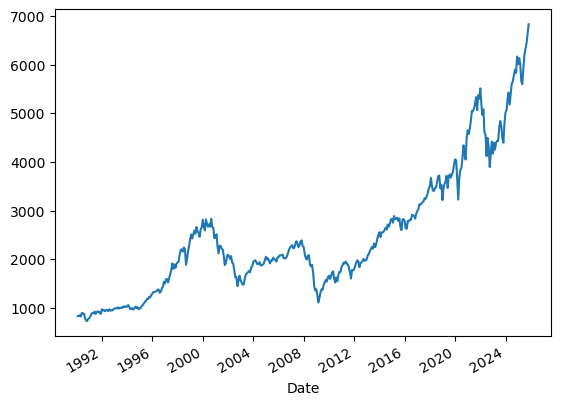

In [7]:
merged_monthly_df_clean_with_changes['SP500 Index Value ($)'].plot()

In [9]:
s = merged_monthly_df_clean_with_changes['SP500 CHANGE RATE'].dropna()
s.describe(percentiles=[.01,.05,.25,.5,.75,.95,.99])

count    429.000000
mean       0.583168
std        4.260488
min      -16.094929
1%       -10.899925
5%        -6.973165
25%       -1.971120
50%        1.042705
75%        3.195388
95%        7.029409
99%        9.134156
max       13.443099
Name: SP500 CHANGE RATE, dtype: float64

In [10]:
tmp = merged_monthly_df_clean_with_changes[['SP500 CHANGE RATE', 'VIX']].dropna()
tmp.corr()

,SP500 CHANGE RATE,VIX
SP500 CHANGE RATE,1.000000,-0.237864
VIX,-0.237864,1.000000


In [12]:
cols = ['SP500 CHANGE RATE',
        'FEDFUNDS CHANGE RATE',
        'CPI CHANGE RATE',
        'UNEMPLOYMENT RATE CHANGE RATE',
        'VIX CHANGE RATE',
        'GPRC CHANGE RATE']
merged_monthly_df_clean_with_changes[cols].corr()['SP500 CHANGE RATE']

SP500 CHANGE RATE                1.000000
FEDFUNDS CHANGE RATE            -0.058215
CPI CHANGE RATE                 -0.067090
UNEMPLOYMENT RATE CHANGE RATE    0.102422
VIX CHANGE RATE                 -0.547795
GPRC CHANGE RATE                -0.155866
Name: SP500 CHANGE RATE, dtype: float64

Text(0.5, 1.0, 'S&P 500 Index Adjusted and Unemployment Rate Since 1990')

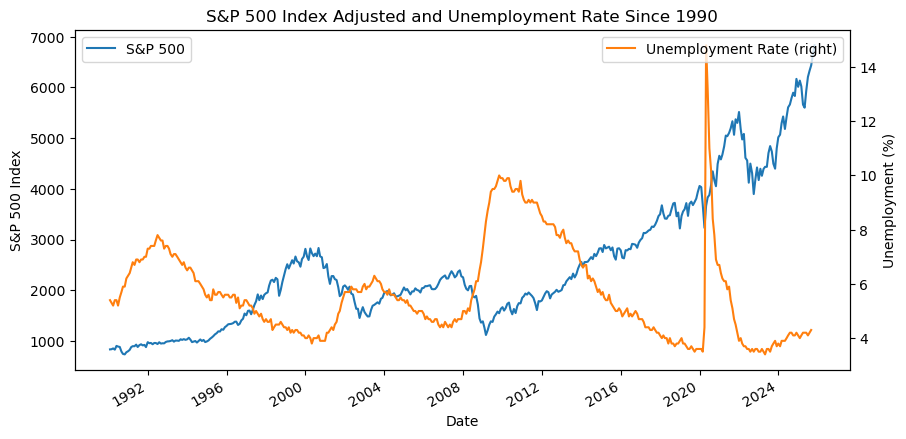

In [49]:
# Putting unemploymenr rate and S&P500 together, we can see that their trends
# are opposite 
ax = merged_monthly_df_clean_with_changes['SP500 Index Value ($)'].plot(
    figsize=(10, 5),
    label='S&P 500',
    color='C0'
)

merged_monthly_df_clean_with_changes['UNEMPLOYMENT RATE'].plot(
    ax=ax,
    secondary_y=True,
    label='Unemployment Rate',
    color='C1'
)

ax.set_ylabel('S&P 500 Index')
ax.right_ax.set_ylabel('Unemployment (%)')

ax.legend(loc='upper left')
ax.right_ax.legend(loc='upper right')
ax.set_title('S&P 500 Index Adjusted and Unemployment Rate Since 1990')


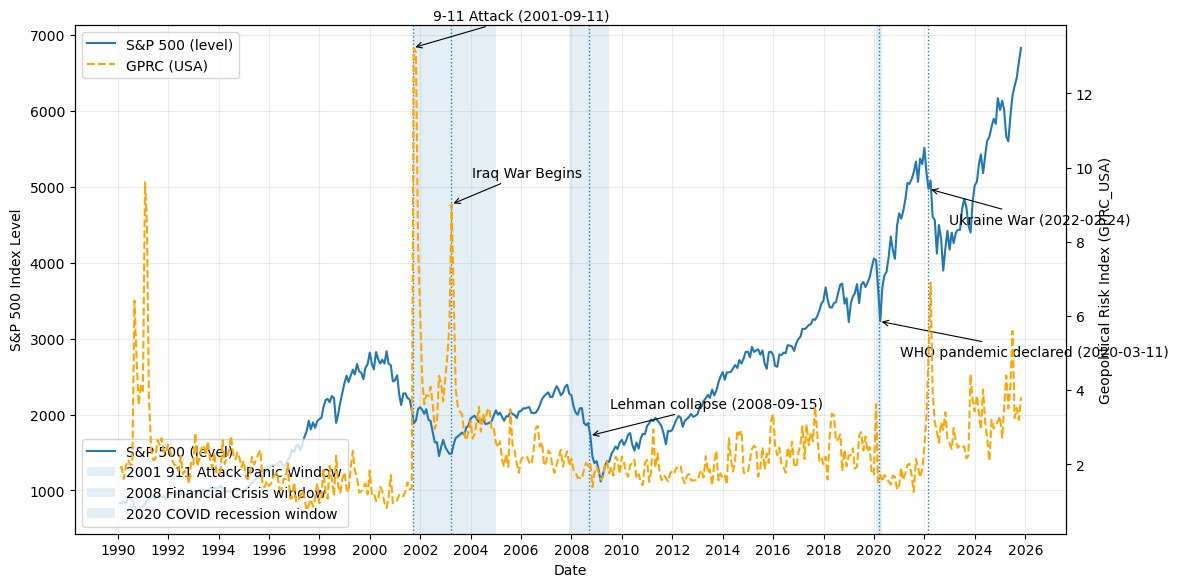

In [46]:
import matplotlib.dates as mdates

df = merged_monthly_df_clean_with_changes.copy()

# Ensure datetime index
df.index = pd.to_datetime(df.index)

fig, ax = plt.subplots(figsize=(12, 6))

# Left axis: S&P 500 level
sp_line = ax.plot(df.index, df['SP500 Index Value ($)'], label='S&P 500 (level)')

ax.set_ylabel('S&P 500 Index Level')
ax.set_xlabel('Date')

# Right axis: Geopolitical Risk (GPRC_USA)
ax2 = ax.twinx()
gprc_line = ax2.plot(df.index, df['GPRC_USA'], linestyle='--', label='GPRC (USA)',color='orange')
ax2.set_ylabel('Geopolitical Risk Index (GPRC_USA)')

# --- Event windows (shaded) ---
#911 Panic: Sep 2001 - Jun 2003
ax.axvspan(pd.Timestamp('2001-09-11'), pd.Timestamp('2005-01-01'), alpha=0.12, label='2001 911 Attack Panic Window')
# NBER Great Recession window (approx): Dec 2007–Jun 2009
ax.axvspan(pd.Timestamp('2007-12-01'), pd.Timestamp('2009-06-30'), alpha=0.12, label='2008 Financial Crisis window')
# COVID recession (approx): Feb–Apr 2020
ax.axvspan(pd.Timestamp('2020-02-01'), pd.Timestamp('2020-04-30'), alpha=0.12, label='2020 COVID recession window')

# 911 Attack
ax.axvline(pd.Timestamp('2001-09-11'),linestyle=':', linewidth=1)
ax2.annotate('9-11 Attack (2001-09-11)', xy=(pd.Timestamp('2001-09-11'), 
             df['GPRC_USA'].loc['2001-09-28']),
            xytext=(15, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', lw=0.8))
# Iraq Attack
ax.axvline(pd.Timestamp('2003-03-20'),linestyle=':', linewidth=1)
ax2.annotate('Iraq War Begins', xy=(pd.Timestamp('2003-03-20'), 
             df['GPRC_USA'].loc['2003-03-31']),
            xytext=(15, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', lw=0.8))
# Lehman Brothers collapse
ax.axvline(pd.Timestamp('2008-09-15'), linestyle=':', linewidth=1)
ax.annotate('Lehman collapse (2008-09-15)', xy=(pd.Timestamp('2008-09-15'), 
             df['SP500 Index Value ($)'].loc['2008-09-30']),
            xytext=(15, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', lw=0.8))

# WHO declares COVID-19 pandemic
ax.axvline(pd.Timestamp('2020-03-11'), linestyle=':', linewidth=1)
# pick a y close to the series around that date to avoid None
y_2020 = df['SP500 Index Value ($)'].loc['2020-03-31']
ax.annotate('WHO pandemic declared (2020-03-11)',
            xy=(pd.Timestamp('2020-03-11'), y_2020),
            xytext=(15, -25), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', lw=0.8))
#Russia Declare War on Ukraine
ax.axvline(pd.Timestamp('2022-02-24'), linestyle=':', linewidth=1)
y_2022 = df['SP500 Index Value ($)'].loc['2022-02-28']
ax.annotate('Ukraine War (2022-02-24)',
            xy=(pd.Timestamp('2022-02-28'), y_2022),
            xytext=(15, -25), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', lw=0.8))
# Formatting: yearly ticks
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))  # every 2 years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Build one combined legend
lines = sp_line + gprc_line
labels = [l.get_label() for l in lines]
legend1 = ax.legend(lines, labels, loc='upper left')
legend2 = ax.legend(loc='lower left')  # picks up the span labels
ax.add_artist(legend1)

ax.grid(alpha=0.25)
fig.tight_layout()
plt.show()

## Hypotheis Testing

In [68]:
#Hypothesis Test, it's clear that S&P 500 adjusted for inflation is not
#staionary, what about the rate of change?
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss

s = df['SP500 Index Value ($)'].dropna()
r = df['SP500 CHANGE RATE'].dropna()

#ADF Null Hypothesis: S&P 500 Rate of Change is non-stationary
#ADF Alternative Hypothesis: S&P 500 Rate of Change is statinoary
#Result: Rejected Null
print('ADF S&P level:', adfuller(s)[1], ' | ADF S&P return:', adfuller(r)[1])
#KPSS Null Hypothesis: S&P 500 Rate of Change is stationary
#KPSS Alternative Hypothesis: S&P 500 Rate of Change is not statinoary
#Result: Fail to reject null
print('KPSS S&P level:', kpss(s, regression='c')[1], ' | KPSS S&P return:', kpss(r, regression='c')[1])

# Autocorrelation in returns
sm.stats.acorr_ljungbox(r, lags=[6,12], return_df=True)
#Result: No correlation discovered
#CONCLUSION: The results show that the rate of change is stationary, and cofirms that
#S&P500 index is non-stationary

ADF S&P level: 0.9946632332603602  | ADF S&P return: 0.0
KPSS S&P level: 0.01  | KPSS S&P return: 0.1


/var/folders/t2/8t74_04d3t5gx4vjqq895zbh0000gn/T/ipykernel_54678/2672862927.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  print('KPSS S&P level:', kpss(s, regression='c')[1], ' | KPSS S&P return:', kpss(r, regression='c')[1])
/var/folders/t2/8t74_04d3t5gx4vjqq895zbh0000gn/T/ipykernel_54678/2672862927.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print('KPSS S&P level:', kpss(s, regression='c')[1], ' | KPSS S&P return:', kpss(r, regression='c')[1])


,lb_stat,lb_pvalue
6,4.838183,0.564729
12,13.814829,0.312689


## Feature Selection

In [67]:
from collections import Counter
# Modeling & CV
from sklearn.linear_model import ElasticNetCV, LassoCV, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr
from sklearn.feature_selection import RFE
df = merged_monthly_df_clean_with_changes.copy()
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index, errors="coerce")

Z = pd.DataFrame({
    "r": df["SP500 CHANGE RATE"],
    "VIX": df["VIX"],
    "dVIX": df["VIX CHANGE RATE"],
    "Unemp": df["UNEMPLOYMENT RATE"],
    "dUnemp": df["UNEMPLOYMENT RATE CHANGE RATE"],
    "FF": df["FEDFUNDS"],
    "dFF": df["FEDFUNDS CHANGE RATE"],
    "CPI": df["CPI"],
    "dCPI": df["CPI CHANGE RATE"],
    "GPRC": df["GPRC_USA"],
    "dGPRC": df["GPRC CHANGE RATE"],
}).dropna()

# optional transforms that are often useful
Z["CPI_YoY"]   = 100*(Z["CPI"]/Z["CPI"].shift(12) - 1)
Z["real_rate"] = Z["FF"] - Z["CPI_YoY"]

# simple tech features
for L in range(1, 4):
    Z[f"r_lag{L}"] = Z["r"].shift(L)
Z["rv_6m"]  = Z["r"].rolling(6).std()
Z["rv_12m"] = Z["r"].rolling(12).std()
cum = (1 + Z["r"]/100.0).cumprod()
roll_max = cum.rolling(12).max()
Z["dd_12m"] = 100*(cum/roll_max - 1)

# add 1–3 lags for key predictors (keep set modest to avoid heavy collinearity)
for col in ["VIX","dVIX","Unemp","dUnemp","FF","dFF","CPI_YoY","real_rate","GPRC","dGPRC","rv_6m","dd_12m"]:
    for L in range(1, 4):
        Z[f"{col}_lag{L}"] = Z[col].shift(L)

# target: next-month return
Y = Z["r"].shift(-1).rename("Y")
X = Z.drop(columns=["r"])
XY = pd.concat([Y, X], axis=1).dropna()
Y = XY.pop("Y")
X = XY

print(f"Samples: {len(X)} | Features: {X.shape[1]}")

# Spearman correlation with next-month return 
# Spearman is robust to monotonic nonlinearity; filter is just a quick screener
filter_scores = {}
for col in X.columns:
    rho, p = spearmanr(X[col].values, Y.values)
    filter_scores[col] = (rho, p)

# rank by |rho|
filter_ranked = sorted(filter_scores.items(), key=lambda kv: -abs(kv[1][0]))
topK = 12  # keep top-K by |rho|
filter_keep = [f for f,_ in filter_ranked[:topK]]

print("\n[Filter] Top-by-|Spearman rho| (rho, p):")
for f,(rho,p) in filter_ranked[:10]:
    print(f"  {f:18s} rho={rho:+.3f}, p={p:.3g}")

# EMBEDDED: LassoCV with time-series split ----------
tscv = TimeSeriesSplit(n_splits=5)
lasso_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("mdl", LassoCV(
        alphas=np.logspace(-4, -1, 200),  # wide grid; adjust if needed
        cv=tscv, max_iter=100000, random_state=42))
])
lasso_pipe.fit(X, Y)
lasso = lasso_pipe.named_steps["mdl"]
lasso_coefs = dict(zip(X.columns, lasso.coef_))
lasso_keep = [f for f,c in lasso_coefs.items() if abs(c) > 1e-10]

print(f"\n[Embedded/LassoCV] Chosen alpha: {lasso.alpha_:.6f}")
print(f"Non-zero features ({len(lasso_keep)}): {sorted(lasso_keep) if lasso_keep else '(none)'}")

# WRAPPER: RFE with Ridge + time-series CV 
# We'll run RFE on the FILTER subset (topK) to keep it light and reduce collinearity.
Xf = X[filter_keep].copy()

ridge_est = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=10.0))
])

target_k = min(5, Xf.shape[1])

# key: provide a function that returns coef_ from the inner 'ridge' step
rfe = RFE(
    estimator=ridge_est,
    n_features_to_select=target_k,
    step=1,
    importance_getter=lambda est: est.named_steps["ridge"].coef_
)
rfe.fit(Xf, Y)

rfe_keep = list(Xf.columns[rfe.get_support()])
print(f"\n[Wrapper/RFE+Ridge] Selected ({len(rfe_keep)}): {rfe_keep}")

# CV score on the selected subset
from sklearn.model_selection import cross_val_score
rfe_pipe = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge(alpha=10.0))])
rfe_cv = cross_val_score(rfe_pipe, Xf[rfe_keep], Y, cv=TimeSeriesSplit(n_splits=5),
                         scoring="neg_mean_squared_error").mean()
print(f"RFE CV mean neg-MSE: {rfe_cv:.4f}")

# CONSENSUS set 
consensus = sorted(set(filter_keep).intersection(lasso_keep).union(rfe_keep))
print(f"\n[Consensus] Union(Filter topK ∪ Lasso ∪ RFE): {consensus if consensus else '(empty)'}")

# Refit a tiny interpretable model on the consensus set 
if len(consensus) >= 1:
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error, r2_score

    tiny_X = X[consensus]
    tiny_pipe = Pipeline([("scaler", StandardScaler()), ("ols", LinearRegression())])

    # simple walk-forward on the small set
    def walk_forward(pipe, X, Y, start_frac=0.6):
        preds, trues, idx = [], [], []
        start = int(len(X)*start_frac)
        for t in range(start, len(X)):
            Xi, Yi = X.iloc[:t], Y.iloc[:t]
            Xt, Yt = X.iloc[t:t+1], Y.iloc[t:t+1]
            pipe.fit(Xi, Yi)
            preds.append(pipe.predict(Xt)[0])
            trues.append(Yt.values[0]); idx.append(Yt.index[0])
        return pd.Series(trues, index=idx), pd.Series(preds, index=idx)

    trues, preds = walk_forward(tiny_pipe, tiny_X, Y)
    mse = mean_squared_error(trues, preds)
    r2  = r2_score(trues, preds)
    hit = (np.sign(trues)==np.sign(preds)).mean()
    bench = pd.Series(Y.mean(), index=trues.index)
    bench_mse = mean_squared_error(trues, bench)
    bench_hit = (np.sign(trues)==np.sign(bench)).mean()

    print("\n[Tiny model on selected features] Walk-forward OOS:")
    print(f"Features: {consensus}")
    print(f"MSE: {mse:.4f} | R^2: {r2:.4f} | Hit: {hit:.3f}  | Bench MSE: {bench_mse:.4f} | Bench Hit: {bench_hit:.3f}")
else:
    print("\n(Tiny model skipped: consensus set is empty.)")

Samples: 411 | Features: 54

[Filter] Top-by-|Spearman rho| (rho, p):
  CPI_YoY            rho=-0.154, p=0.00175
  CPI_YoY_lag1       rho=-0.123, p=0.0129
  CPI_YoY_lag2       rho=-0.106, p=0.0311
  CPI_YoY_lag3       rho=-0.102, p=0.0386
  real_rate          rho=+0.098, p=0.0476
  rv_6m              rho=+0.086, p=0.0817
  rv_12m             rho=+0.082, p=0.0959
  VIX                rho=+0.077, p=0.118
  rv_6m_lag1         rho=+0.074, p=0.132
  GPRC_lag3          rho=-0.074, p=0.134

[Embedded/LassoCV] Chosen alpha: 0.100000
Non-zero features (19): ['CPI', 'CPI_YoY', 'GPRC', 'GPRC_lag3', 'Unemp', 'Unemp_lag1', 'VIX', 'dFF', 'dFF_lag1', 'dFF_lag3', 'dGPRC_lag1', 'dUnemp_lag2', 'dVIX_lag1', 'dd_12m_lag2', 'r_lag1', 'r_lag2', 'real_rate', 'rv_12m', 'rv_6m']

[Wrapper/RFE+Ridge] Selected (5): ['CPI_YoY', 'CPI_YoY_lag1', 'real_rate', 'VIX', 'dFF_lag1']
RFE CV mean neg-MSE: -20.4304

[Consensus] Union(Filter topK ∪ Lasso ∪ RFE): ['CPI_YoY', 'CPI_YoY_lag1', 'GPRC_lag3', 'VIX', 'dFF_lag1', 're

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Pick dataframe
if 'merged_monthly_df_with_changes' in globals():
    df = merged_monthly_df_with_changes.copy()
elif 'merged_monthly_df' in globals():
    df = merged_monthly_df.copy()
else:
    raise ValueError("Run the earlier cells that create the monthly merged dataframe first.")

# 2. Ensure datetime index
if not isinstance(df.index, pd.DatetimeIndex):
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')
    elif 'date_month' in df.columns:
        df['date_month'] = pd.to_datetime(df['date_month'].astype(str).str.replace('.', '-') + '-01', errors='coerce')
        df = df.set_index('date_month')
    else:
        raise ValueError("No 'Date' or 'date_month' column available.")

df = df.sort_index()

# 3. Auto-detect columns
def find_col(keyword):
    keyword = keyword.upper()
    candidates = [c for c in df.columns if keyword in c.upper()]
    return candidates[0] if candidates else None

sp_col = find_col('SP500')
gpr_col = find_col('GPR')
cpi_col = find_col('CPI')
unemp_col = find_col('UNEMPLOYMENT')
vix_col = find_col('VIX')

cols_to_plot = [c for c in [sp_col, gpr_col, cpi_col, unemp_col, vix_col] if c is not None]

if len(cols_to_plot) < 2:
    raise ValueError("Not enough expected columns found (SP500, GPR, CPI, UNEMPLOYMENT, VIX).")

plot_df = df[cols_to_plot].dropna()

# 4. Normalize each series
norm_df = plot_df.copy()
for col in norm_df.columns:
    col_min = norm_df[col].min()
    col_max = norm_df[col].max()
    if col_max > col_min:
        norm_df[col] = (norm_df[col] - col_min) / (col_max - col_min)

# 5. Plot
plt.figure(figsize=(12, 6))
for col in norm_df.columns:
    plt.plot(norm_df.index, norm_df[col], label=col, linewidth=2)

plt.title("Normalized Monthly Trends in S&P 500 and Key Variables")
plt.xlabel("Year")
plt.ylabel("Normalized Value (0–1)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

: 